In [ ]:
# train a classical generative adversarial network on a gaussian probability distribution
import numpy as np
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Dropout, Reshape, LeakyReLU, Flatten, BatchNormalization
from matplotlib import pyplot

In [ ]:
# define the standalone discriminator model
def define_discriminator(n_inputs=1, alpha=0.2, dropout=0.2):
    model = Sequential()
        
    model.add(Dense(200, use_bias=False, input_dim=n_inputs))
    model.add(Reshape((10,10,2)))
    
    model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_normal'))
    model.add(LeakyReLU(alpha=alpha))
    
    model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_normal'))
    model.add(LeakyReLU(alpha=alpha))

    model.add(Conv2D(16, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_normal'))
    model.add(LeakyReLU(alpha=alpha))

    model.add(Conv2D(8, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_normal'))

    model.add(Flatten())
    model.add(LeakyReLU(alpha=alpha))
    model.add(Dropout(dropout)) 

    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs=1, alpha=0.2):
    model = Sequential()

    model.add(Dense(200, input_dim=latent_dim, kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))
    model.add(Reshape((10,10,2)))

    model.add(Conv2DTranspose(32, kernel_size=2, strides=1, padding=('same'), use_bias=False, kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))

    model.add(Conv2DTranspose(16, kernel_size=2, strides=1, padding=('same'), use_bias=False, kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))

    model.add(Conv2DTranspose(8, kernel_size=3, strides=1, padding=('same'), use_bias=False, kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))

    model.add(Flatten())

    model.add(Dense(n_outputs, activation='tanh'))
    
    return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model
 
# generate real samples with class labels
def generate_real_samples(samples, sigma=0.25, mu=0.0):
    # generate samples from the distribution
    s = np.random.normal(mu, sigma, samples)
    # shape array
    X = s.reshape(samples, 1)
    # generate class labels
    y = np.ones((samples, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, samples):
    # generate points in the latent space
    x_input = randn(latent_dim * samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(samples, latent_dim)
    return x_input
 
# use the generator to generate fake examples, with class labels
def generate_fake_samples(generator, latent_dim, samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, samples)
    # predict outputs
    X = generator.predict(x_input)
    # shape array
    X = X.reshape(samples, 1)
    # create class labels
    y = np.zeros((samples, 1))
    return X, y
 
# evaluate the discriminator and plot real and fake samples
def summarize_performance(epoch, generator, discriminator, latent_dim, samples, nbins):
    # prepare real samples
    x_real, y_real = generate_real_samples(100000)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, 100000)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('epoch: ',epoch, 'acc_real: ', acc_real, 'acc_fake: ', acc_fake)
    # histogram plot real and fake data points
    pyplot.hist(x_real, np.linspace(-1.0, 1.0, nbins+1), color='red', label='real', alpha=0.5)
    pyplot.hist(x_fake, np.linspace(-1.0, 1.0, nbins+1), color='blue', label='fake', alpha=0.5)
    #yplot.hist(x_real, color='red', label='real', alpha=0.5)
    #yplot.hist(x_fake, color='blue', label='fake', alpha=0.5)
    pyplot.legend()
    pyplot.show()
    

    # serialize weights to HDF5
    generator.save_weights(str(epoch)+"_generator.h5")
    print("Saved generator to disk")
    discriminator.save_weights(str(epoch)+"_discriminator.h5")
    print("Saved discriminator to disk")
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=30000, samples=256, nbins=49, n_eval=250):
    # determine half the size of one batch, for updating the discriminator
    half_samples = int(samples / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_samples)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_samples)
        # update discriminator
        d_model.trainable = True
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, samples)
        # create inverted labels for the fake samples
        y_gan = np.ones((samples, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim, samples, nbins)

epoch:  249 acc_real:  0.774370014667511 acc_fake:  0.9470700025558472


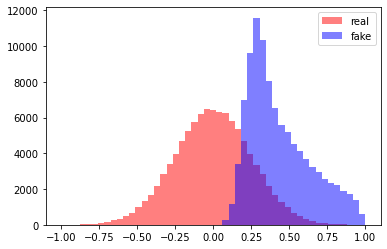

Saved generator to disk
Saved discriminator to disk
epoch:  499 acc_real:  0.6478000283241272 acc_fake:  0.4170199930667877


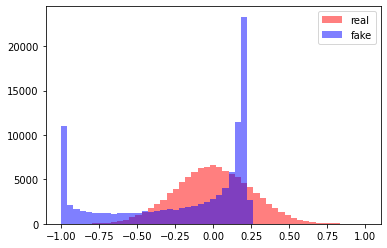

Saved generator to disk
Saved discriminator to disk
epoch:  749 acc_real:  0.7804499864578247 acc_fake:  0.34512001276016235


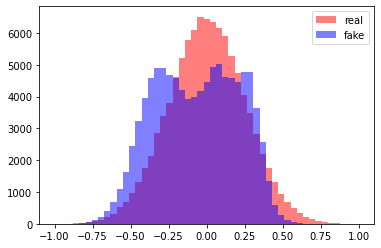

Saved generator to disk
Saved discriminator to disk
epoch:  999 acc_real:  0.6280099749565125 acc_fake:  0.39572998881340027


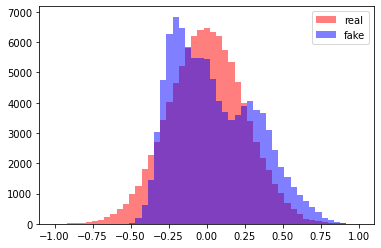

Saved generator to disk
Saved discriminator to disk
epoch:  1249 acc_real:  0.2915099859237671 acc_fake:  0.6087499856948853


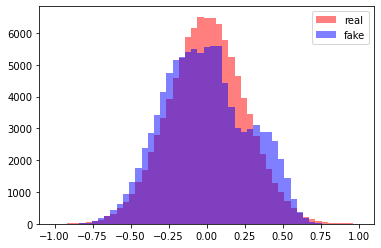

Saved generator to disk
Saved discriminator to disk
epoch:  1499 acc_real:  0.6778900027275085 acc_fake:  0.3256399929523468


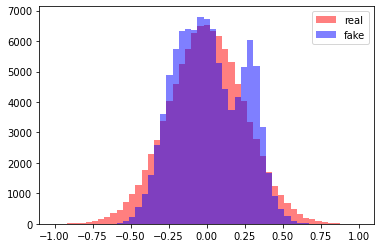

Saved generator to disk
Saved discriminator to disk
epoch:  1749 acc_real:  0.13158999383449554 acc_fake:  0.9551699757575989


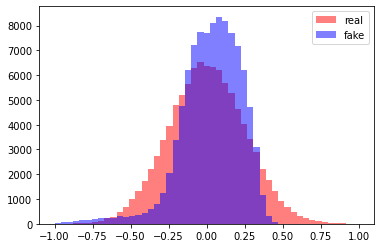

Saved generator to disk
Saved discriminator to disk
epoch:  1999 acc_real:  0.42028000950813293 acc_fake:  0.6244400143623352


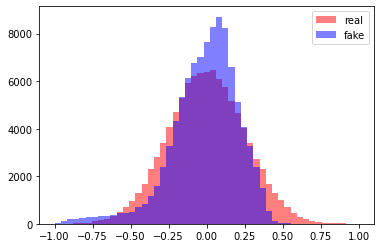

Saved generator to disk
Saved discriminator to disk
epoch:  2249 acc_real:  0.9919099807739258 acc_fake:  0.011529999785125256


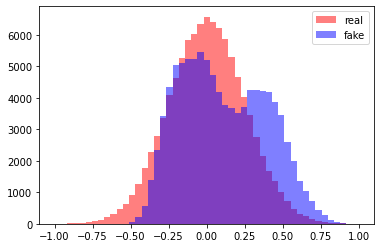

Saved generator to disk
Saved discriminator to disk
epoch:  2499 acc_real:  0.12100999802350998 acc_fake:  0.9526500105857849


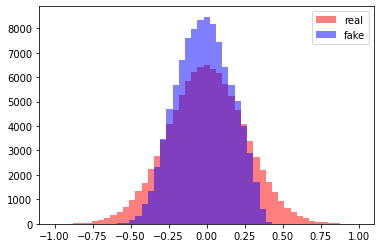

Saved generator to disk
Saved discriminator to disk
epoch:  2749 acc_real:  0.2234099954366684 acc_fake:  0.8166999816894531


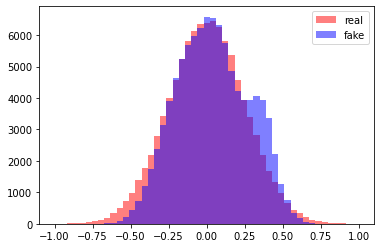

Saved generator to disk
Saved discriminator to disk
epoch:  2999 acc_real:  0.26809000968933105 acc_fake:  0.5920500159263611


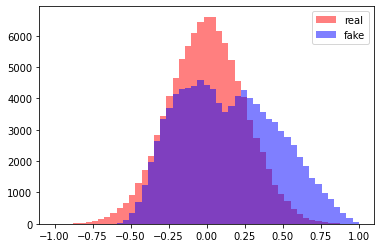

Saved generator to disk
Saved discriminator to disk
epoch:  3249 acc_real:  0.25001999735832214 acc_fake:  0.7553200125694275


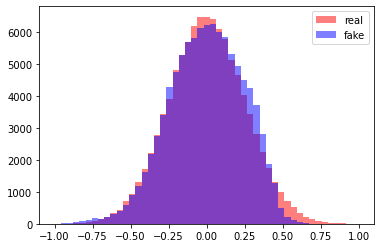

Saved generator to disk
Saved discriminator to disk
epoch:  3499 acc_real:  0.17840999364852905 acc_fake:  0.918690025806427


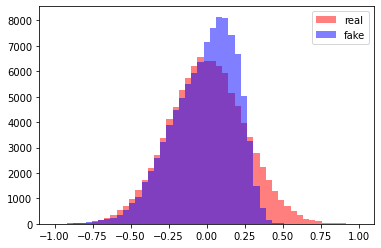

Saved generator to disk
Saved discriminator to disk
epoch:  3749 acc_real:  0.7621700167655945 acc_fake:  0.23263999819755554


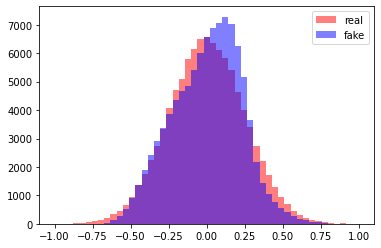

Saved generator to disk
Saved discriminator to disk
epoch:  3999 acc_real:  0.9859399795532227 acc_fake:  0.004110000096261501


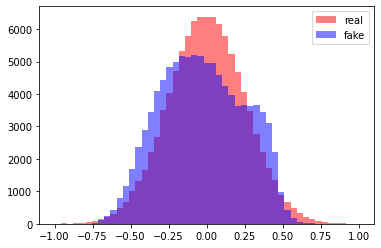

Saved generator to disk
Saved discriminator to disk
epoch:  4249 acc_real:  0.17012999951839447 acc_fake:  0.8527100086212158


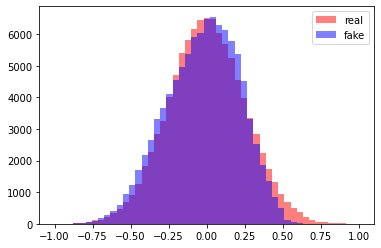

Saved generator to disk
Saved discriminator to disk
epoch:  4499 acc_real:  0.3055399954319 acc_fake:  0.7410299777984619


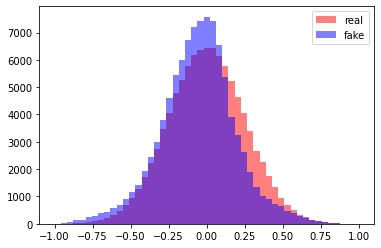

Saved generator to disk
Saved discriminator to disk
epoch:  4749 acc_real:  0.5466099977493286 acc_fake:  0.45723000168800354


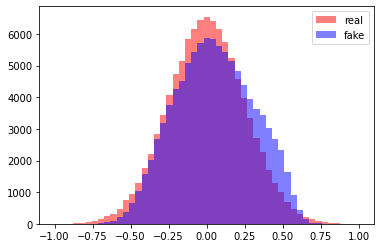

Saved generator to disk
Saved discriminator to disk
epoch:  4999 acc_real:  0.993149995803833 acc_fake:  0.002319999970495701


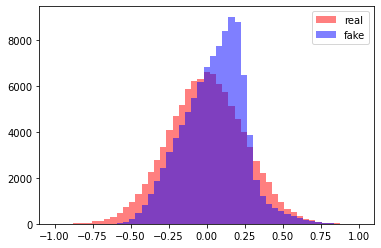

Saved generator to disk
Saved discriminator to disk
epoch:  5249 acc_real:  0.9938300251960754 acc_fake:  0.004290000069886446


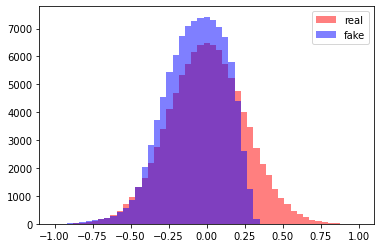

Saved generator to disk
Saved discriminator to disk
epoch:  5499 acc_real:  0.4664599895477295 acc_fake:  0.4243899881839752


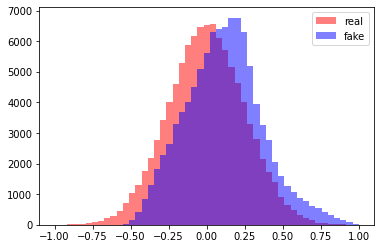

Saved generator to disk
Saved discriminator to disk
epoch:  5749 acc_real:  0.7845600247383118 acc_fake:  0.24652999639511108


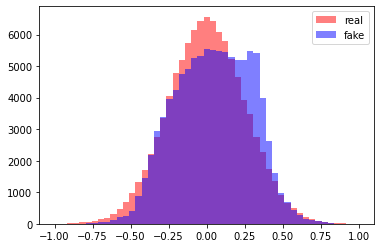

Saved generator to disk
Saved discriminator to disk
epoch:  5999 acc_real:  0.9028199911117554 acc_fake:  0.18419000506401062


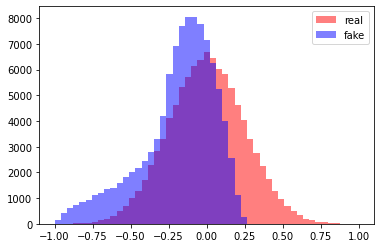

Saved generator to disk
Saved discriminator to disk
epoch:  6249 acc_real:  0.9973999857902527 acc_fake:  0.0


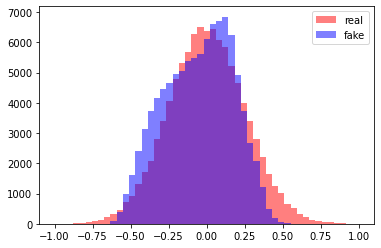

Saved generator to disk
Saved discriminator to disk
epoch:  6499 acc_real:  0.44290000200271606 acc_fake:  0.6529200077056885


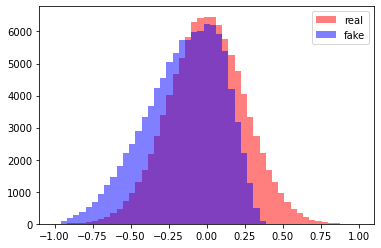

Saved generator to disk
Saved discriminator to disk
epoch:  6749 acc_real:  0.9591599702835083 acc_fake:  0.003329999977722764


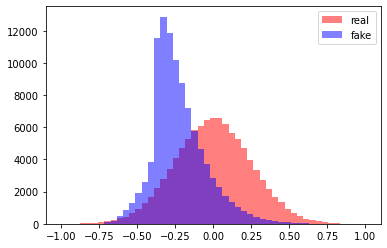

Saved generator to disk
Saved discriminator to disk
epoch:  6999 acc_real:  0.549019992351532 acc_fake:  0.4099999964237213


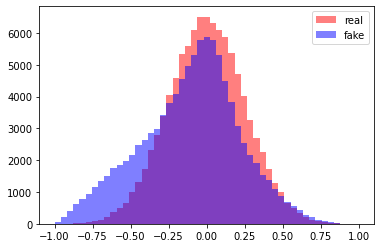

Saved generator to disk
Saved discriminator to disk
epoch:  7249 acc_real:  0.8654099702835083 acc_fake:  0.03889000043272972


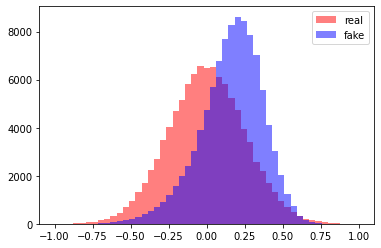

Saved generator to disk
Saved discriminator to disk
epoch:  7499 acc_real:  0.6837900280952454 acc_fake:  0.48871999979019165


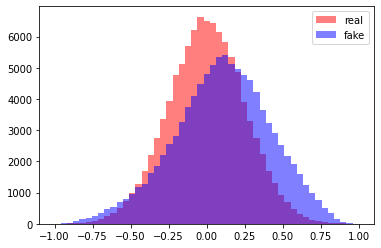

Saved generator to disk
Saved discriminator to disk
epoch:  7749 acc_real:  0.16672000288963318 acc_fake:  0.7252600193023682


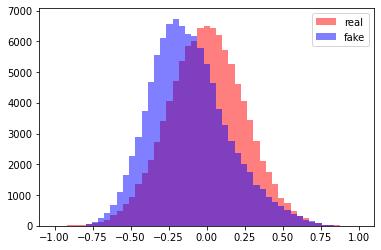

Saved generator to disk
Saved discriminator to disk
epoch:  7999 acc_real:  0.7258800268173218 acc_fake:  0.8461300134658813


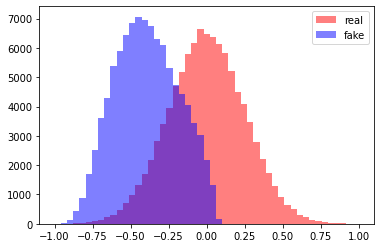

Saved generator to disk
Saved discriminator to disk
epoch:  8249 acc_real:  0.5735200047492981 acc_fake:  0.3641299903392792


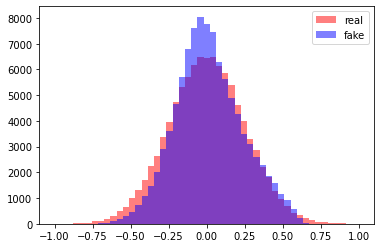

Saved generator to disk
Saved discriminator to disk
epoch:  8499 acc_real:  0.4784899950027466 acc_fake:  0.7625899910926819


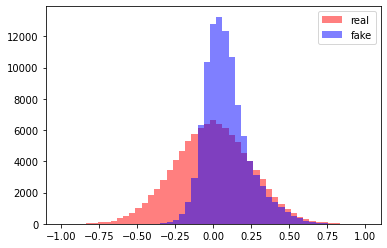

Saved generator to disk
Saved discriminator to disk
epoch:  8749 acc_real:  0.46160000562667847 acc_fake:  0.5067700147628784


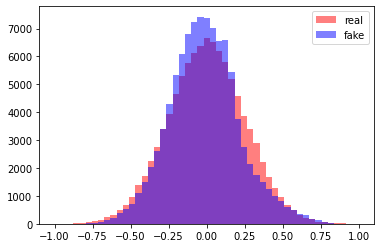

Saved generator to disk
Saved discriminator to disk
epoch:  8999 acc_real:  0.3407599925994873 acc_fake:  0.6456800103187561


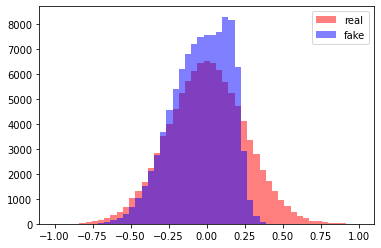

Saved generator to disk
Saved discriminator to disk
epoch:  9249 acc_real:  0.8214200139045715 acc_fake:  0.3671000003814697


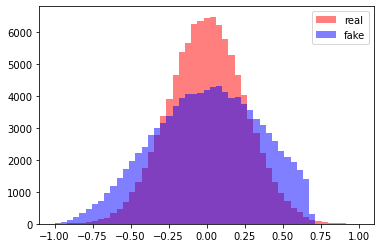

Saved generator to disk
Saved discriminator to disk
epoch:  9499 acc_real:  0.5613399744033813 acc_fake:  0.5428500175476074


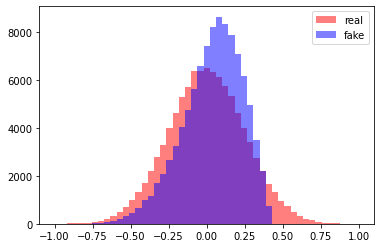

Saved generator to disk
Saved discriminator to disk
epoch:  9749 acc_real:  0.428739994764328 acc_fake:  0.6314299702644348


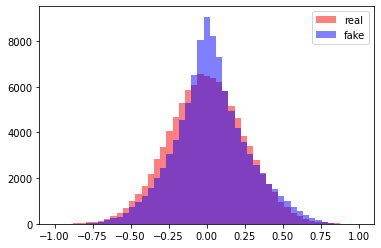

Saved generator to disk
Saved discriminator to disk
epoch:  9999 acc_real:  0.20730000734329224 acc_fake:  0.7608199715614319


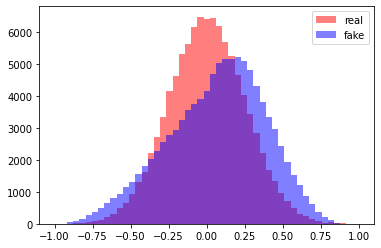

Saved generator to disk
Saved discriminator to disk
epoch:  10249 acc_real:  0.5762900114059448 acc_fake:  0.464709997177124


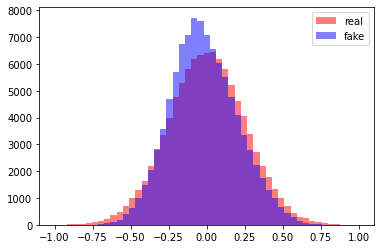

Saved generator to disk
Saved discriminator to disk
epoch:  10499 acc_real:  0.48454999923706055 acc_fake:  0.5616400241851807


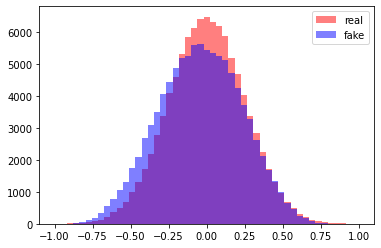

Saved generator to disk
Saved discriminator to disk
epoch:  10749 acc_real:  0.5776299834251404 acc_fake:  0.4247699975967407


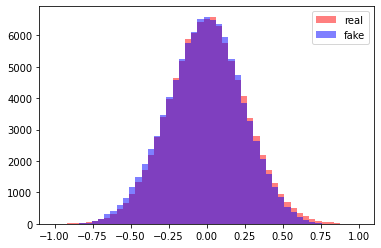

Saved generator to disk
Saved discriminator to disk
epoch:  10999 acc_real:  0.34272000193595886 acc_fake:  0.5104900002479553


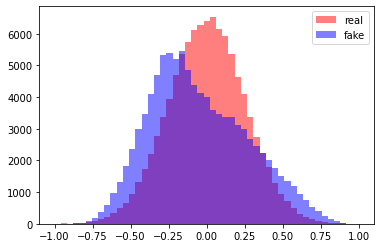

Saved generator to disk
Saved discriminator to disk
epoch:  11249 acc_real:  0.6347900032997131 acc_fake:  0.37171998620033264


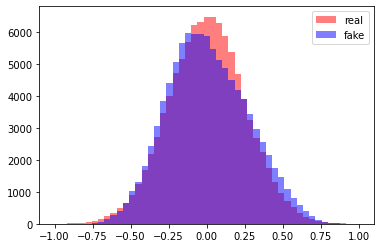

Saved generator to disk
Saved discriminator to disk
epoch:  11499 acc_real:  0.5871300101280212 acc_fake:  0.637939989566803


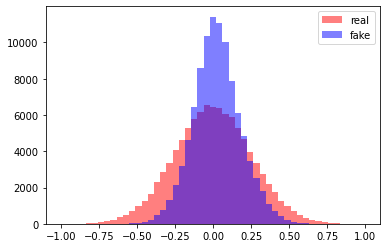

Saved generator to disk
Saved discriminator to disk
epoch:  11749 acc_real:  0.185029998421669 acc_fake:  0.9871000051498413


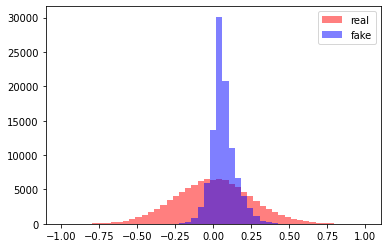

Saved generator to disk
Saved discriminator to disk
epoch:  11999 acc_real:  0.7270299792289734 acc_fake:  0.44863998889923096


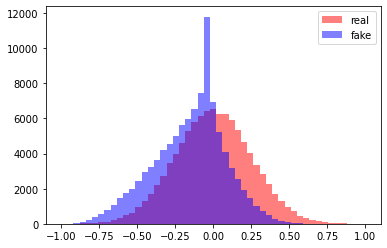

Saved generator to disk
Saved discriminator to disk
epoch:  12249 acc_real:  0.37922000885009766 acc_fake:  0.8470699787139893


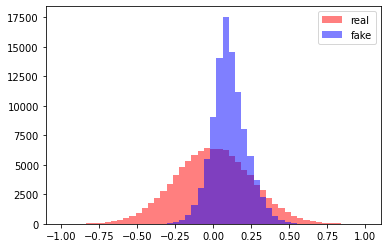

Saved generator to disk
Saved discriminator to disk
epoch:  12499 acc_real:  0.6615800261497498 acc_fake:  0.034619998186826706


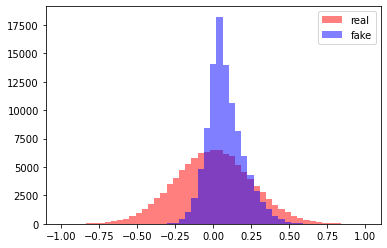

Saved generator to disk
Saved discriminator to disk
epoch:  12749 acc_real:  0.39447999000549316 acc_fake:  0.7418799996376038


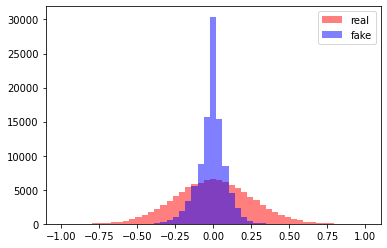

Saved generator to disk
Saved discriminator to disk
epoch:  12999 acc_real:  0.8595200181007385 acc_fake:  0.5967900156974792


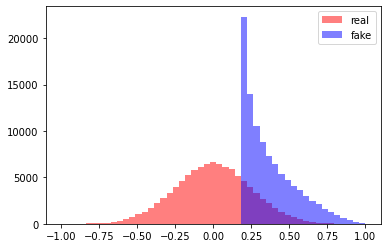

Saved generator to disk
Saved discriminator to disk
epoch:  13249 acc_real:  0.49665001034736633 acc_fake:  0.5717200040817261


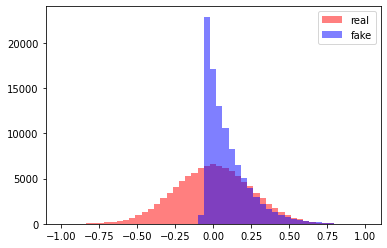

Saved generator to disk
Saved discriminator to disk
epoch:  13499 acc_real:  0.5716300010681152 acc_fake:  0.5930200219154358


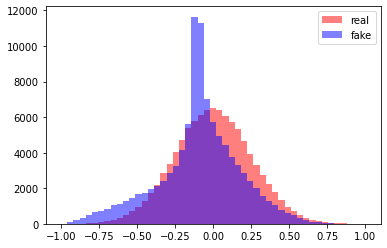

Saved generator to disk
Saved discriminator to disk
epoch:  13749 acc_real:  0.4801500141620636 acc_fake:  0.7384399771690369


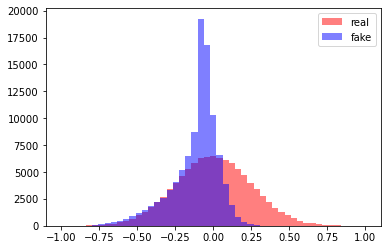

Saved generator to disk
Saved discriminator to disk
epoch:  13999 acc_real:  0.47786998748779297 acc_fake:  0.7006099820137024


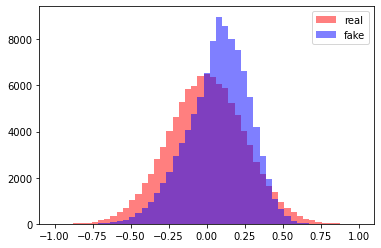

Saved generator to disk
Saved discriminator to disk
epoch:  14249 acc_real:  0.8437399864196777 acc_fake:  0.35418999195098877


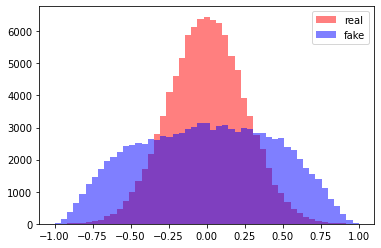

Saved generator to disk
Saved discriminator to disk
epoch:  14499 acc_real:  0.7421000003814697 acc_fake:  0.42932000756263733


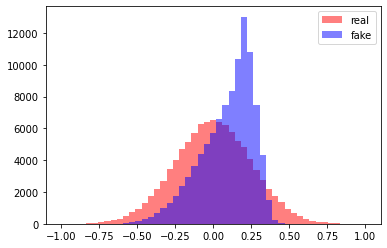

Saved generator to disk
Saved discriminator to disk
epoch:  14749 acc_real:  0.6420300006866455 acc_fake:  0.4991399943828583


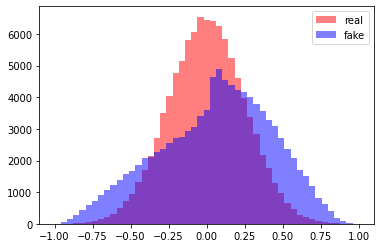

Saved generator to disk
Saved discriminator to disk
epoch:  14999 acc_real:  0.28953999280929565 acc_fake:  0.9267200231552124


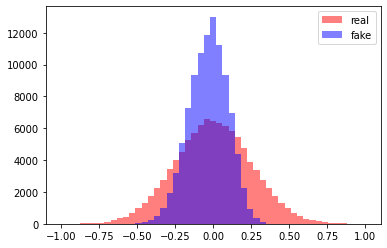

Saved generator to disk
Saved discriminator to disk
epoch:  15249 acc_real:  0.5809400081634521 acc_fake:  0.3285900056362152


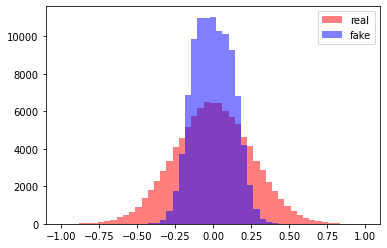

Saved generator to disk
Saved discriminator to disk
epoch:  15499 acc_real:  0.3183099925518036 acc_fake:  0.6685199737548828


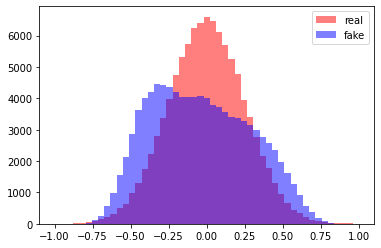

Saved generator to disk
Saved discriminator to disk
epoch:  15749 acc_real:  0.11264000087976456 acc_fake:  0.9206900000572205


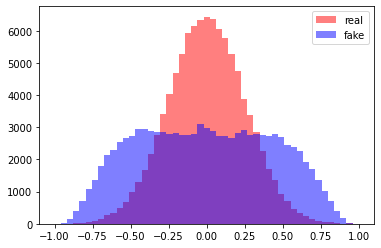

Saved generator to disk
Saved discriminator to disk
epoch:  15999 acc_real:  0.8769299983978271 acc_fake:  0.004900000058114529


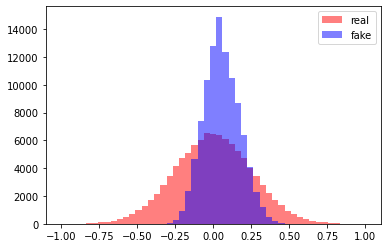

Saved generator to disk
Saved discriminator to disk
epoch:  16249 acc_real:  0.0006300000241026282 acc_fake:  0.9992499947547913


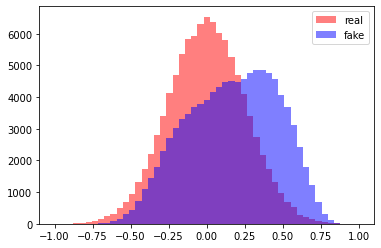

Saved generator to disk
Saved discriminator to disk
epoch:  16499 acc_real:  0.10389000177383423 acc_fake:  0.8198500275611877


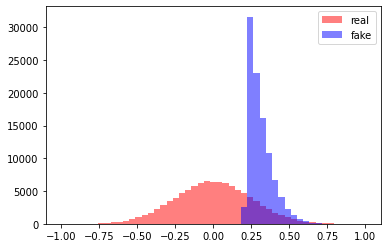

Saved generator to disk
Saved discriminator to disk
epoch:  16749 acc_real:  0.4323999881744385 acc_fake:  0.7878299951553345


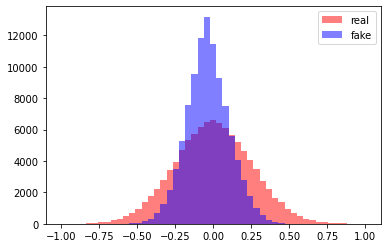

Saved generator to disk
Saved discriminator to disk
epoch:  16999 acc_real:  0.5706800222396851 acc_fake:  0.6680999994277954


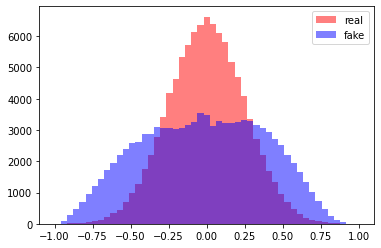

Saved generator to disk
Saved discriminator to disk
epoch:  17249 acc_real:  0.1349399983882904 acc_fake:  0.939740002155304


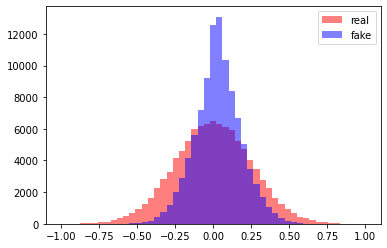

Saved generator to disk
Saved discriminator to disk
epoch:  17499 acc_real:  0.3722200095653534 acc_fake:  0.688480019569397


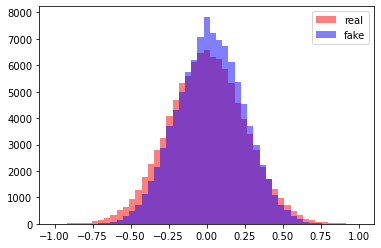

Saved generator to disk
Saved discriminator to disk
epoch:  17749 acc_real:  0.35016000270843506 acc_fake:  0.637440025806427


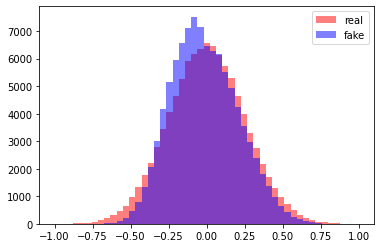

Saved generator to disk
Saved discriminator to disk
epoch:  17999 acc_real:  0.6672199964523315 acc_fake:  0.3167400062084198


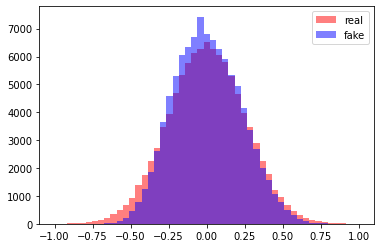

Saved generator to disk
Saved discriminator to disk
epoch:  18249 acc_real:  0.5661900043487549 acc_fake:  0.4155600070953369


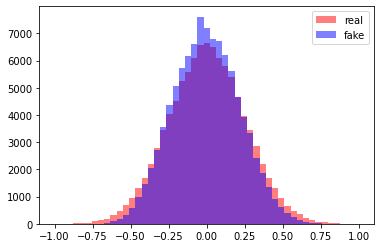

Saved generator to disk
Saved discriminator to disk
epoch:  18499 acc_real:  0.4750399887561798 acc_fake:  0.656220018863678


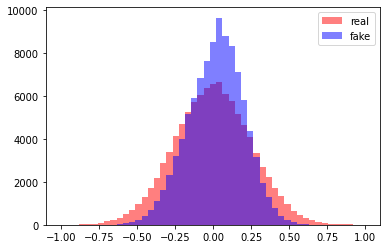

Saved generator to disk
Saved discriminator to disk
epoch:  18749 acc_real:  0.4713999927043915 acc_fake:  0.5489500164985657


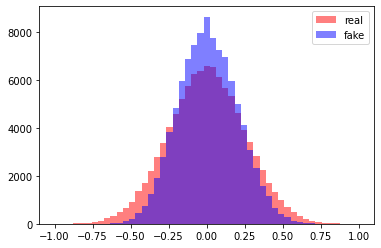

Saved generator to disk
Saved discriminator to disk
epoch:  18999 acc_real:  0.5855299830436707 acc_fake:  0.4251900017261505


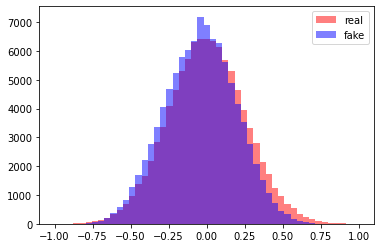

Saved generator to disk
Saved discriminator to disk
epoch:  19249 acc_real:  0.588729977607727 acc_fake:  0.4326600134372711


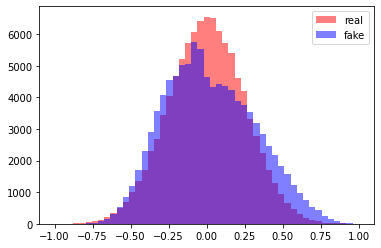

Saved generator to disk
Saved discriminator to disk
epoch:  19499 acc_real:  0.5032899975776672 acc_fake:  0.45723000168800354


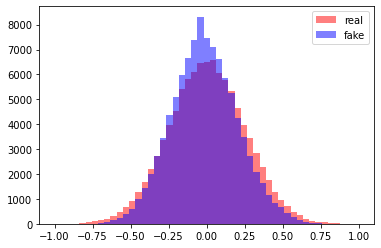

Saved generator to disk
Saved discriminator to disk
epoch:  19749 acc_real:  0.945330023765564 acc_fake:  0.0007800000021234155


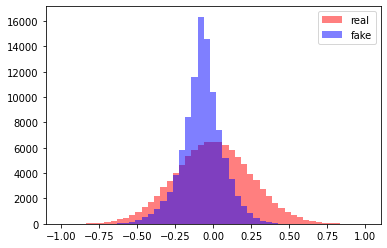

Saved generator to disk
Saved discriminator to disk
epoch:  19999 acc_real:  1.0 acc_fake:  0.0


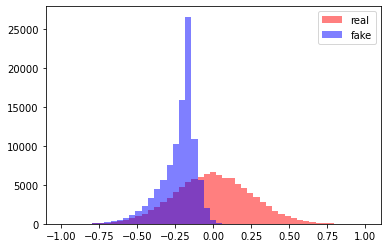

Saved generator to disk
Saved discriminator to disk
epoch:  20249 acc_real:  0.49880000948905945 acc_fake:  0.5611500144004822


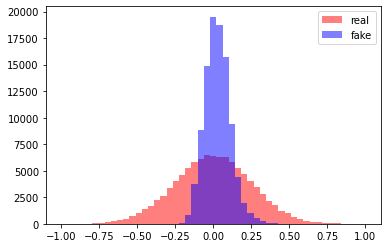

Saved generator to disk
Saved discriminator to disk
epoch:  20499 acc_real:  0.26513999700546265 acc_fake:  0.6915299892425537


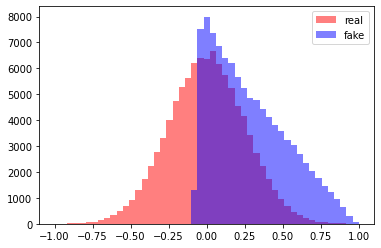

Saved generator to disk
Saved discriminator to disk
epoch:  20749 acc_real:  0.1842000037431717 acc_fake:  0.6969199776649475


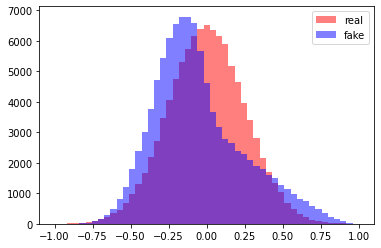

Saved generator to disk
Saved discriminator to disk
epoch:  20999 acc_real:  0.6668800115585327 acc_fake:  0.6057000160217285


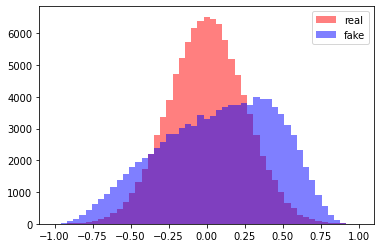

Saved generator to disk
Saved discriminator to disk
epoch:  21249 acc_real:  0.4755299985408783 acc_fake:  0.548009991645813


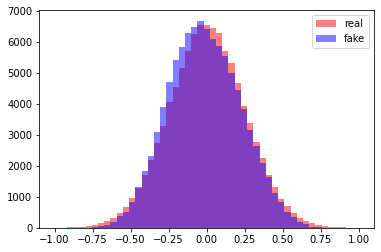

Saved generator to disk
Saved discriminator to disk
epoch:  21499 acc_real:  0.32607001066207886 acc_fake:  0.6680300235748291


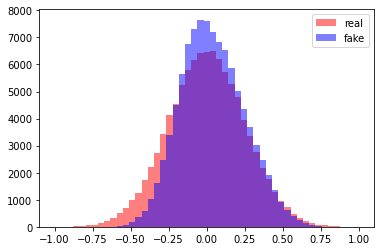

Saved generator to disk
Saved discriminator to disk
epoch:  21749 acc_real:  0.9999899864196777 acc_fake:  0.0


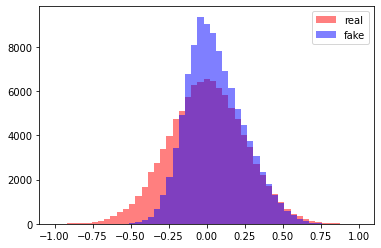

Saved generator to disk
Saved discriminator to disk
epoch:  21999 acc_real:  0.3476499915122986 acc_fake:  0.5399100184440613


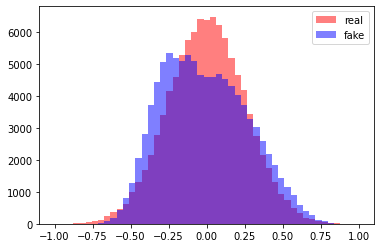

Saved generator to disk
Saved discriminator to disk
epoch:  22249 acc_real:  0.0524899996817112 acc_fake:  0.988789975643158


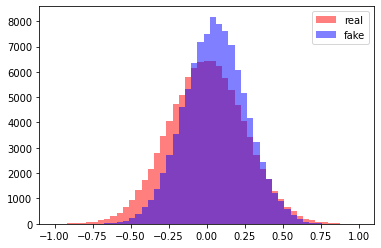

Saved generator to disk
Saved discriminator to disk
epoch:  22499 acc_real:  0.6656399965286255 acc_fake:  0.3548699915409088


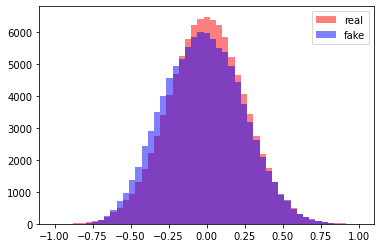

Saved generator to disk
Saved discriminator to disk
epoch:  22749 acc_real:  0.45131000876426697 acc_fake:  0.6290500164031982


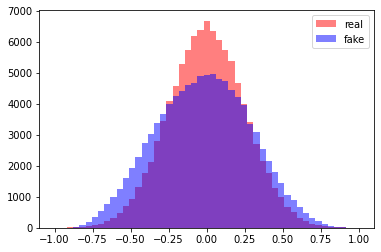

Saved generator to disk
Saved discriminator to disk
epoch:  22999 acc_real:  0.33006998896598816 acc_fake:  0.7354199886322021


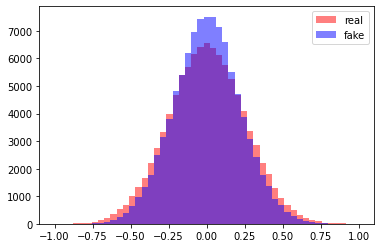

Saved generator to disk
Saved discriminator to disk
epoch:  23249 acc_real:  0.1728300005197525 acc_fake:  0.8594899773597717


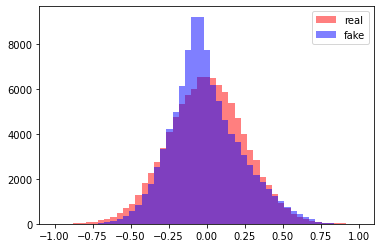

Saved generator to disk
Saved discriminator to disk
epoch:  23499 acc_real:  0.913640022277832 acc_fake:  0.390529990196228


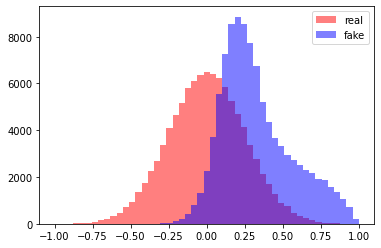

Saved generator to disk
Saved discriminator to disk
epoch:  23749 acc_real:  0.6936399936676025 acc_fake:  0.9061099886894226


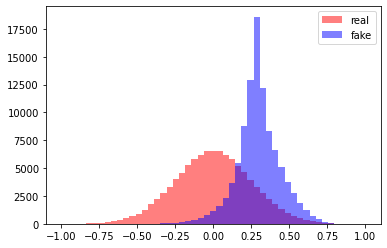

Saved generator to disk
Saved discriminator to disk
epoch:  23999 acc_real:  0.00686000008136034 acc_fake:  0.983240008354187


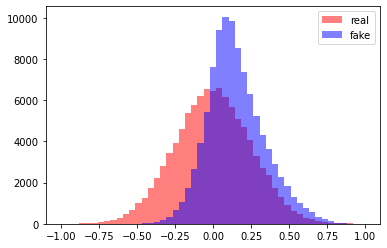

Saved generator to disk
Saved discriminator to disk
epoch:  24249 acc_real:  0.01656999997794628 acc_fake:  1.0


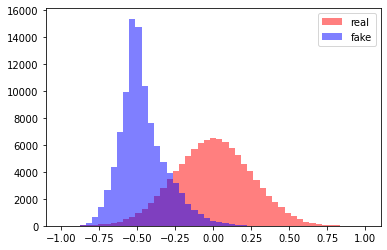

Saved generator to disk
Saved discriminator to disk
epoch:  24499 acc_real:  0.24652999639511108 acc_fake:  0.8514500260353088


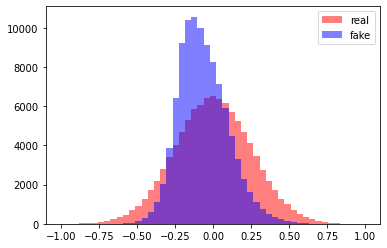

Saved generator to disk
Saved discriminator to disk
epoch:  24749 acc_real:  0.0003000000142492354 acc_fake:  0.9999899864196777


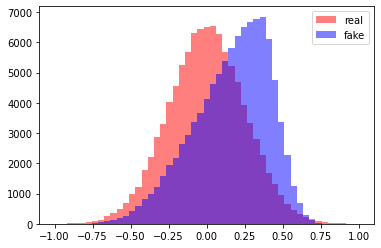

Saved generator to disk
Saved discriminator to disk
epoch:  24999 acc_real:  0.5382500290870667 acc_fake:  0.5577600002288818


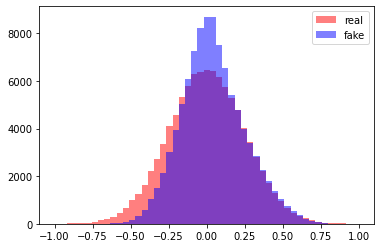

Saved generator to disk
Saved discriminator to disk
epoch:  25249 acc_real:  0.41290000081062317 acc_fake:  0.5984799861907959


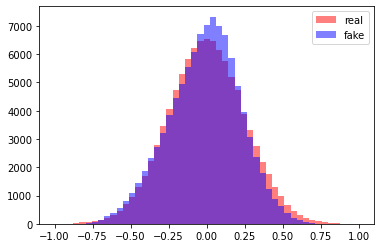

Saved generator to disk
Saved discriminator to disk
epoch:  25499 acc_real:  0.6482800245285034 acc_fake:  0.2913999855518341


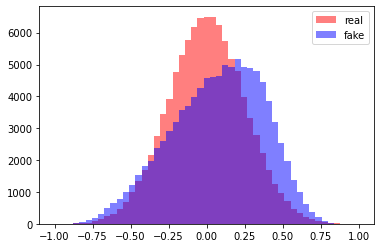

Saved generator to disk
Saved discriminator to disk
epoch:  25749 acc_real:  0.2991200089454651 acc_fake:  0.8030499815940857


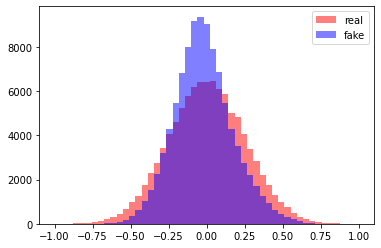

Saved generator to disk
Saved discriminator to disk
epoch:  25999 acc_real:  0.48945000767707825 acc_fake:  0.4879699945449829


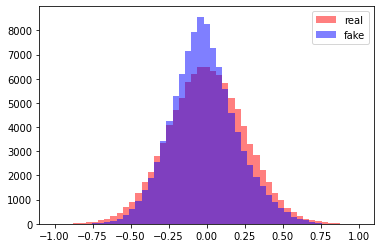

Saved generator to disk
Saved discriminator to disk
epoch:  26249 acc_real:  0.5367100238800049 acc_fake:  0.251120001077652


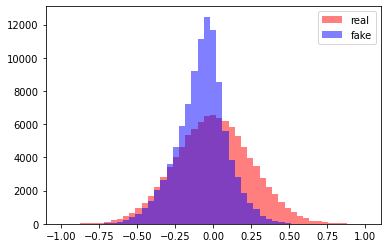

Saved generator to disk
Saved discriminator to disk
epoch:  26499 acc_real:  0.7109599709510803 acc_fake:  0.5902000069618225


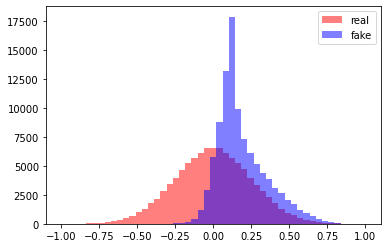

Saved generator to disk
Saved discriminator to disk
epoch:  26749 acc_real:  0.5174700021743774 acc_fake:  0.8336300253868103


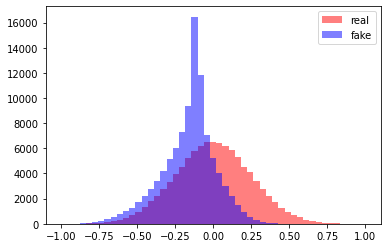

Saved generator to disk
Saved discriminator to disk
epoch:  26999 acc_real:  0.19687999784946442 acc_fake:  0.8261799812316895


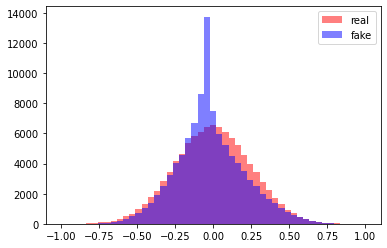

Saved generator to disk
Saved discriminator to disk
epoch:  27249 acc_real:  0.5877599716186523 acc_fake:  0.3686999976634979


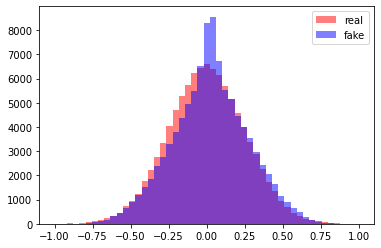

Saved generator to disk
Saved discriminator to disk
epoch:  27499 acc_real:  0.2809999883174896 acc_fake:  0.7952700257301331


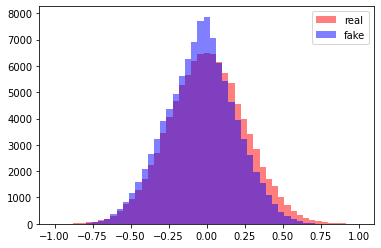

Saved generator to disk
Saved discriminator to disk
epoch:  27749 acc_real:  0.831030011177063 acc_fake:  0.19808000326156616


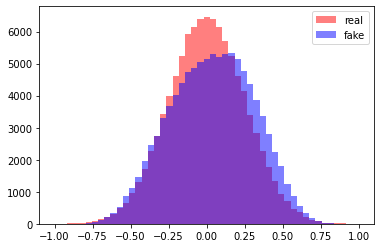

Saved generator to disk
Saved discriminator to disk
epoch:  27999 acc_real:  0.006769999861717224 acc_fake:  0.9894400238990784


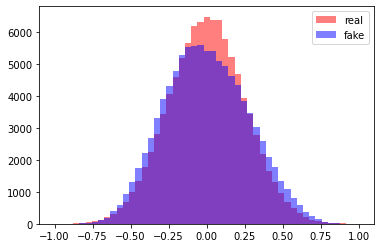

Saved generator to disk
Saved discriminator to disk
epoch:  28249 acc_real:  0.3931899964809418 acc_fake:  0.6255800127983093


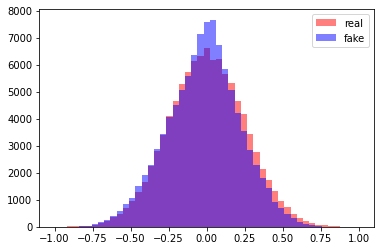

Saved generator to disk
Saved discriminator to disk
epoch:  28499 acc_real:  0.8570700287818909 acc_fake:  0.23145000636577606


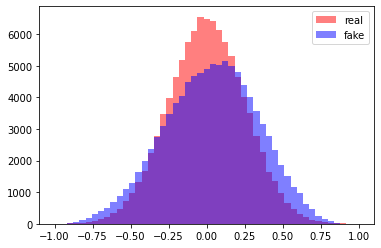

Saved generator to disk
Saved discriminator to disk
epoch:  28749 acc_real:  0.467849999666214 acc_fake:  0.5928900241851807


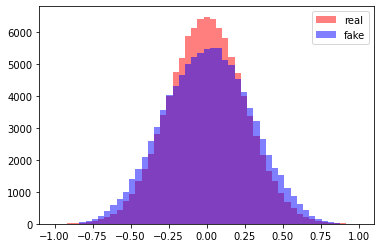

Saved generator to disk
Saved discriminator to disk
epoch:  28999 acc_real:  0.5282800197601318 acc_fake:  0.4870699942111969


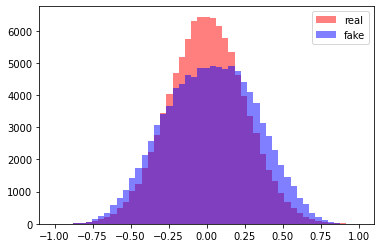

Saved generator to disk
Saved discriminator to disk
epoch:  29249 acc_real:  0.9794899821281433 acc_fake:  0.0004299999854993075


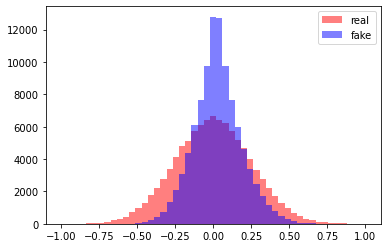

Saved generator to disk
Saved discriminator to disk
epoch:  29499 acc_real:  0.27035000920295715 acc_fake:  0.7030100226402283


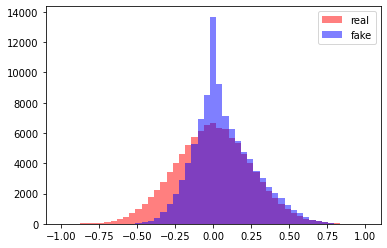

Saved generator to disk
Saved discriminator to disk
epoch:  29749 acc_real:  0.48412999510765076 acc_fake:  1.0


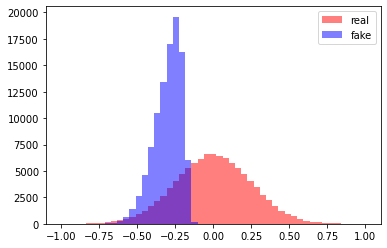

Saved generator to disk
Saved discriminator to disk
epoch:  29999 acc_real:  0.6212199926376343 acc_fake:  0.4883800148963928


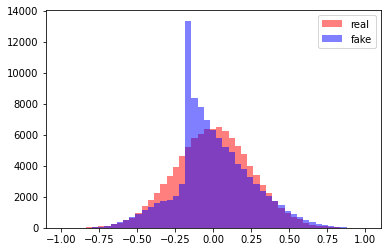

Saved generator to disk
Saved discriminator to disk


In [ ]:
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# serialize generator and discriminator to JSON
gen_model_json = generator.to_json()
with open("generator.json", "w") as json_file:
    json_file.write(gen_model_json)
disc_model_json = discriminator.to_json()
with open("discriminator.json", "w") as json_file:
    json_file.write(disc_model_json)
# train model
train(generator, discriminator, gan_model, latent_dim)

In [ ]:
# train model
train(generator, discriminator, gan_model, latent_dim)

KeyboardInterrupt: ignored

# Nueva sección